# Phase 4: Spatial Block Split + Train/Val/Test-Zuweisung

**Ziel:** Räumlich disjunkte Splits für robuste Validierung

**Input:**
- `trees_balanced_hamburg.gpkg`
- `trees_balanced_berlin.gpkg`
- `trees_balanced_rostock.gpkg`
- `city_boundaries.gpkg`

**Output:**
- `hamburg_train.gpkg` (80% Blöcke)
- `hamburg_val.gpkg` (20% Blöcke)
- `berlin_train.gpkg` (80% Blöcke)
- `berlin_val.gpkg` (20% Blöcke)
- `rostock_zero_shot.gpkg` (80% → Exp. 2 Zero-Shot Test)
- `rostock_finetune_eval.gpkg` (20% → Exp. 3 Fine-Tuning Eval)
- `block_assignments.csv`
- `split_statistics.csv`

**Methodik:**
- 500×500m Spatial Blocks
- StratifiedGroupKFold für Hamburg/Berlin (genus-stratifiziert, block-gruppiert)
- Random stratifizierter Split für Rostock (80/20)

## 1. Setup: Google Drive Mount + Imports

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Imports
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from shapely.geometry import box, Point
from sklearn.model_selection import StratifiedGroupKFold
import warnings
warnings.filterwarnings('ignore')

# Plotting Style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print('✅ Imports erfolgreich')

✅ Imports erfolgreich


## 2. Konfiguration

In [8]:
DRIVE_ROOT = Path("/content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit")

# Input-Pfade
FEATURES_DIR = DRIVE_ROOT / 'data' / 'features'
BOUNDARIES_PATH = DRIVE_ROOT / 'data' / 'boundaries' / 'city_boundaries.gpkg'

# Output-Pfade
SPLITS_DIR = DRIVE_ROOT / 'data' / 'splits'
SPLITS_DIR.mkdir(parents=True, exist_ok=True)

# Städte
CITIES = ['Hamburg', 'Berlin', 'Rostock']

# Spatial Block Config
BLOCK_SIZE_M = 500  # 500×500m Blöcke
TRAIN_SPLIT = 0.8    # 80% Train, 20% Val/Test
RANDOM_STATE = 42    # Reproduzierbarkeit

# Viable Genera (aus Phase 3)
VIABLE_GENERA = ['TILIA', 'ACER', 'QUERCUS', 'FRAXINUS', 'BETULA', 'SORBUS', 'PRUNUS']

print(f'Konfiguration:')
print(f'  Drive Root: {DRIVE_ROOT}')
print(f'  Block Size: {BLOCK_SIZE_M}×{BLOCK_SIZE_M}m')
print(f'  Train/Val Split: {TRAIN_SPLIT}/{1-TRAIN_SPLIT}')
print(f'  Viable Genera: {len(VIABLE_GENERA)}')

Konfiguration:
  Drive Root: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit
  Block Size: 500×500m
  Train/Val Split: 0.8/0.19999999999999996
  Viable Genera: 7


## 3. Daten laden

In [9]:
# Lade Baumkataster
trees = {}
for city in CITIES:
    path = FEATURES_DIR / f'trees_balanced_{city}.gpkg'
    print(f'Lade {city}...')
    gdf = gpd.read_file(path)
    trees[city] = gdf
    print(f'  {len(gdf):,} Bäume, {gdf["genus_latin"].nunique()} Gattungen')

# Lade Stadtgrenzen
print(f'\nLade Stadtgrenzen...')
boundaries = gpd.read_file(BOUNDARIES_PATH)
print(f'  {len(boundaries)} Städte geladen')

print('\n✅ Daten erfolgreich geladen')

Lade Hamburg...
  10,500 Bäume, 7 Gattungen
Lade Berlin...
  10,288 Bäume, 7 Gattungen
Lade Rostock...
  8,078 Bäume, 7 Gattungen

Lade Stadtgrenzen...
  3 Städte geladen

✅ Daten erfolgreich geladen


## 4. Spatial Block Grid erstellen

Erstelle 500×500m Blöcke für jede Stadt und weise jedem Baum eine `block_id` zu.

In [11]:
def create_spatial_blocks(gdf, block_size_m, city_name):
    """
    Erstellt reguläres Grid von Blöcken und weist jedem Punkt eine block_id zu.

    Args:
        gdf: GeoDataFrame mit Punktgeometrien
        block_size_m: Blockgröße in Metern
        city_name: Name der Stadt (für block_id Präfix)

    Returns:
        gdf: GeoDataFrame mit neuer Spalte 'block_id'
        blocks_gdf: GeoDataFrame mit Block-Polygonen
    """
    minx, miny, maxx, maxy = gdf.total_bounds

    x_coords = np.arange(minx, maxx, block_size_m)
    y_coords = np.arange(miny, maxy, block_size_m)

    blocks = []
    block_ids = []

    for i, x in enumerate(x_coords):
        for j, y in enumerate(y_coords):
            block_poly = box(x, y, x + block_size_m, y + block_size_m)
            blocks.append(block_poly)
            block_ids.append(f"{city_name}_{i}_{j}")

    blocks_gdf = gpd.GeoDataFrame(
        {'block_id': block_ids, 'geometry': blocks},
        crs=gdf.crs
    )

    gdf_with_blocks = gpd.sjoin(
        gdf,
        blocks_gdf[['block_id', 'geometry']],
        how='left',
        predicate='within'
    )

    gdf_with_blocks = gdf_with_blocks.drop(columns=['index_right'], errors='ignore')
    gdf_with_blocks = gdf_with_blocks.drop_duplicates(subset=['tree_id'], keep='first')

    missing_blocks_mask = gdf_with_blocks['block_id'].isna()
    if missing_blocks_mask.any():
        print(f"  ⚠️  {missing_blocks_mask.sum()} Bäume ohne Block-Zuweisung → nearest join")

        gdf_missing_for_nearest_join = gdf_with_blocks[missing_blocks_mask].copy()
        gdf_missing_for_nearest_join = gdf_missing_for_nearest_join.drop(columns=['block_id', 'index_right'], errors='ignore')

        gdf_nearest_assigned = gpd.sjoin_nearest(
            gdf_missing_for_nearest_join,
            blocks_gdf[['block_id', 'geometry']],
            how='left'
        )

        gdf_nearest_assigned = gdf_nearest_assigned.drop_duplicates(subset=['tree_id'], keep='first')

        original_index = gdf_with_blocks.index
        gdf_with_blocks.set_index('tree_id', inplace=True)
        gdf_nearest_assigned.set_index('tree_id', inplace=True)

        gdf_with_blocks['block_id'].update(gdf_nearest_assigned['block_id'])

        gdf_with_blocks.reset_index(inplace=True)
        gdf_nearest_assigned.reset_index(inplace=True)
        gdf_with_blocks.index = original_index

    return gdf_with_blocks, blocks_gdf


# Erstelle Blöcke für alle Städte
trees_with_blocks = {}
blocks_gdf_dict = {}

for city in CITIES:
    print(f'\nErstelle Blöcke für {city.capitalize()}...')
    gdf, blocks_gdf = create_spatial_blocks(trees[city], BLOCK_SIZE_M, city)
    trees_with_blocks[city] = gdf
    blocks_gdf_dict[city] = blocks_gdf

    n_blocks = gdf['block_id'].nunique()
    trees_per_block = gdf.groupby('block_id').size()
    print(f'  {n_blocks} Blöcke erstellt')
    print(f'  Bäume pro Block: Median={trees_per_block.median():.0f}, Range=[{trees_per_block.min()}-{trees_per_block.max()}]')

print('\n✅ Spatial Blocks erstellt')



Erstelle Blöcke für Hamburg...
  ⚠️  39 Bäume ohne Block-Zuweisung → nearest join
  1687 Blöcke erstellt
  Bäume pro Block: Median=4, Range=[1-65]

Erstelle Blöcke für Berlin...
  ⚠️  2 Bäume ohne Block-Zuweisung → nearest join
  2246 Blöcke erstellt
  Bäume pro Block: Median=3, Range=[1-84]

Erstelle Blöcke für Rostock...
  ⚠️  38 Bäume ohne Block-Zuweisung → nearest join
  386 Blöcke erstellt
  Bäume pro Block: Median=15, Range=[1-135]

✅ Spatial Blocks erstellt


## 5. Hamburg/Berlin: 80/20 Split mit StratifiedGroupKFold

In [13]:
def stratified_spatial_split(gdf, train_split=0.8, random_state=42):
    """
    Erstellt Train/Val Split mit StratifiedGroupKFold.

    Args:
        gdf: GeoDataFrame mit 'block_id' und 'genus_latin'
        train_split: Anteil Train-Daten (default: 0.8)
        random_state: Random Seed

    Returns:
        train_gdf, val_gdf, train_blocks, val_blocks
    """
    # Anzahl Folds berechnen (5 Folds → 1 Fold = 20% Val)
    n_splits = int(1 / (1 - train_split))

    # StratifiedGroupKFold
    sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Encode genus_latin als numerische Labels
    genus_labels = gdf['genus_latin'].astype('category').cat.codes
    block_ids = gdf['block_id']

    # Dummy X (wird nicht genutzt, aber von sklearn erwartet)
    X = np.zeros((len(gdf), 1))

    # Erster Split = Val, Rest = Train
    train_idx, val_idx = next(sgkf.split(X, y=genus_labels, groups=block_ids))

    train_gdf = gdf.iloc[train_idx].copy()
    val_gdf = gdf.iloc[val_idx].copy()

    train_blocks = train_gdf['block_id'].unique().tolist()
    val_blocks = val_gdf['block_id'].unique().tolist()

    return train_gdf, val_gdf, train_blocks, val_blocks


# Split Hamburg
print('Split Hamburg...')
hamburg_train, hamburg_val, hamburg_train_blocks, hamburg_val_blocks = stratified_spatial_split(
    trees_with_blocks['Hamburg'], TRAIN_SPLIT, RANDOM_STATE
)
print(f'  Train: {len(hamburg_train):,} Bäume, {len(hamburg_train_blocks)} Blöcke')
print(f'  Val: {len(hamburg_val):,} Bäume, {len(hamburg_val_blocks)} Blöcke')

# Split Berlin
print('\nSplit Berlin...')
berlin_train, berlin_val, berlin_train_blocks, berlin_val_blocks = stratified_spatial_split(
    trees_with_blocks['Berlin'], TRAIN_SPLIT, RANDOM_STATE
)
print(f'  Train: {len(berlin_train):,} Bäume, {len(berlin_train_blocks)} Blöcke')
print(f'  Val: {len(berlin_val):,} Bäume, {len(berlin_val_blocks)} Blöcke')

print('\n✅ Hamburg/Berlin Splits erstellt')

Split Hamburg...
  Train: 8,371 Bäume, 1352 Blöcke
  Val: 2,129 Bäume, 335 Blöcke

Split Berlin...
  Train: 8,299 Bäume, 1789 Blöcke
  Val: 1,989 Bäume, 457 Blöcke

✅ Hamburg/Berlin Splits erstellt


## 6. Rostock: 80/20 Split für Zero-Shot Test / Fine-Tuning Eval

In [14]:
def stratified_random_split(gdf, train_split=0.8, random_state=42):
    """
    Erstellt stratifizierten Random Split (block-basiert).

    Args:
        gdf: GeoDataFrame mit 'block_id' und 'genus_latin'
        train_split: Anteil Train-Daten
        random_state: Random Seed

    Returns:
        train_gdf, test_gdf, train_blocks, test_blocks
    """
    from sklearn.model_selection import train_test_split

    # Alle Blöcke
    all_blocks = gdf['block_id'].unique()

    # Gattungsverteilung pro Block (für Stratifikation)
    block_genus = gdf.groupby('block_id')['genus_latin'].apply(lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0])

    # Train/Test Split auf Block-Ebene
    train_blocks, test_blocks = train_test_split(
        all_blocks,
        train_size=train_split,
        stratify=block_genus,
        random_state=random_state
    )

    train_gdf = gdf[gdf['block_id'].isin(train_blocks)].copy()
    test_gdf = gdf[gdf['block_id'].isin(test_blocks)].copy()

    return train_gdf, test_gdf, train_blocks.tolist(), test_blocks.tolist()


# Split Rostock: 80% Zero-Shot Test, 20% Fine-Tuning Eval
print('Split Rostock...')
rostock_zero_shot, rostock_finetune_eval, rostock_zs_blocks, rostock_ft_blocks = stratified_random_split(
    trees_with_blocks['Rostock'], TRAIN_SPLIT, RANDOM_STATE
)
print(f'  Zero-Shot Test: {len(rostock_zero_shot):,} Bäume, {len(rostock_zs_blocks)} Blöcke')
print(f'  Fine-Tuning Eval: {len(rostock_finetune_eval):,} Bäume, {len(rostock_ft_blocks)} Blöcke')

print('\n✅ Rostock Splits erstellt')

Split Rostock...
  Zero-Shot Test: 6,675 Bäume, 308 Blöcke
  Fine-Tuning Eval: 1,403 Bäume, 78 Blöcke

✅ Rostock Splits erstellt


## 7. Validierung: Spatial Disjunktheit

In [15]:
print('=== CHECK 1: Spatial Disjunktheit ===')
print('\nHamburg:')
overlap_hamburg = set(hamburg_train_blocks).intersection(hamburg_val_blocks)
if overlap_hamburg:
    print(f'  ❌ FEHLER: {len(overlap_hamburg)} überlappende Blöcke!')
else:
    print(f'  ✅ Train/Val räumlich disjunkt')

print('\nBerlin:')
overlap_berlin = set(berlin_train_blocks).intersection(berlin_val_blocks)
if overlap_berlin:
    print(f'  ❌ FEHLER: {len(overlap_berlin)} überlappende Blöcke!')
else:
    print(f'  ✅ Train/Val räumlich disjunkt')

print('\nRostock:')
overlap_rostock = set(rostock_zs_blocks).intersection(rostock_ft_blocks)
if overlap_rostock:
    print(f'  ❌ FEHLER: {len(overlap_rostock)} überlappende Blöcke!')
else:
    print(f'  ✅ Zero-Shot Test / Fine-Tuning Eval räumlich disjunkt')

=== CHECK 1: Spatial Disjunktheit ===

Hamburg:
  ✅ Train/Val räumlich disjunkt

Berlin:
  ✅ Train/Val räumlich disjunkt

Rostock:
  ✅ Zero-Shot Test / Fine-Tuning Eval räumlich disjunkt


## 8. Validierung: Gattungsverteilung

In [16]:
def check_genus_distribution(gdf_dict, split_name, min_samples=10):
    """
    Prüft, ob alle viable Genera in jedem Split vorhanden sind.
    """
    print(f'\n{split_name}:')
    for name, gdf in gdf_dict.items():
        genus_counts = gdf['genus_latin'].value_counts()
        missing = [g for g in VIABLE_GENERA if g not in genus_counts.index]
        low_count = [g for g in VIABLE_GENERA if g in genus_counts.index and genus_counts[g] < min_samples]

        if missing or low_count:
            print(f'  ⚠️  {name}:')
            if missing:
                print(f'      Fehlend: {missing}')
            if low_count:
                print(f'      Zu wenige (<{min_samples}): {low_count}')
        else:
            print(f'  ✅ {name}: Alle {len(VIABLE_GENERA)} Gattungen vorhanden (>={min_samples} Samples)')

print('=== CHECK 2: Gattungsverteilung ===')

check_genus_distribution(
    {'Hamburg Train': hamburg_train, 'Hamburg Val': hamburg_val},
    'Hamburg'
)

check_genus_distribution(
    {'Berlin Train': berlin_train, 'Berlin Val': berlin_val},
    'Berlin'
)

check_genus_distribution(
    {'Rostock Zero-Shot': rostock_zero_shot, 'Rostock Fine-Tune Eval': rostock_finetune_eval},
    'Rostock'
)

=== CHECK 2: Gattungsverteilung ===

Hamburg:
  ✅ Hamburg Train: Alle 7 Gattungen vorhanden (>=10 Samples)
  ✅ Hamburg Val: Alle 7 Gattungen vorhanden (>=10 Samples)

Berlin:
  ✅ Berlin Train: Alle 7 Gattungen vorhanden (>=10 Samples)
  ✅ Berlin Val: Alle 7 Gattungen vorhanden (>=10 Samples)

Rostock:
  ✅ Rostock Zero-Shot: Alle 7 Gattungen vorhanden (>=10 Samples)
  ✅ Rostock Fine-Tune Eval: Alle 7 Gattungen vorhanden (>=10 Samples)


## 9. Validierung: Block-Balance

In [17]:
print('=== CHECK 3: Block-Balance ===')

for city, gdf in [('Hamburg Train', hamburg_train), ('Hamburg Val', hamburg_val),
                  ('Berlin Train', berlin_train), ('Berlin Val', berlin_val),
                  ('Rostock Zero-Shot', rostock_zero_shot), ('Rostock Fine-Tune Eval', rostock_finetune_eval)]:
    block_sizes = gdf.groupby('block_id').size()
    print(f'\n{city}:')
    print(f'  Blöcke: {len(block_sizes)}')
    print(f'  Bäume pro Block: Median={block_sizes.median():.0f}, Q25={block_sizes.quantile(0.25):.0f}, Q75={block_sizes.quantile(0.75):.0f}')
    print(f'  Range: [{block_sizes.min()}-{block_sizes.max()}]')

=== CHECK 3: Block-Balance ===

Hamburg Train:
  Blöcke: 1352
  Bäume pro Block: Median=4, Q25=2, Q75=8
  Range: [1-65]

Hamburg Val:
  Blöcke: 335
  Bäume pro Block: Median=4, Q25=2, Q75=8
  Range: [1-55]

Berlin Train:
  Blöcke: 1789
  Bäume pro Block: Median=3, Q25=2, Q75=6
  Range: [1-84]

Berlin Val:
  Blöcke: 457
  Bäume pro Block: Median=3, Q25=2, Q75=5
  Range: [1-31]

Rostock Zero-Shot:
  Blöcke: 308
  Bäume pro Block: Median=16, Q25=5, Q75=31
  Range: [1-135]

Rostock Fine-Tune Eval:
  Blöcke: 78
  Bäume pro Block: Median=10, Q25=4, Q75=24
  Range: [1-93]


## 10. Visualisierung: Spatial Maps

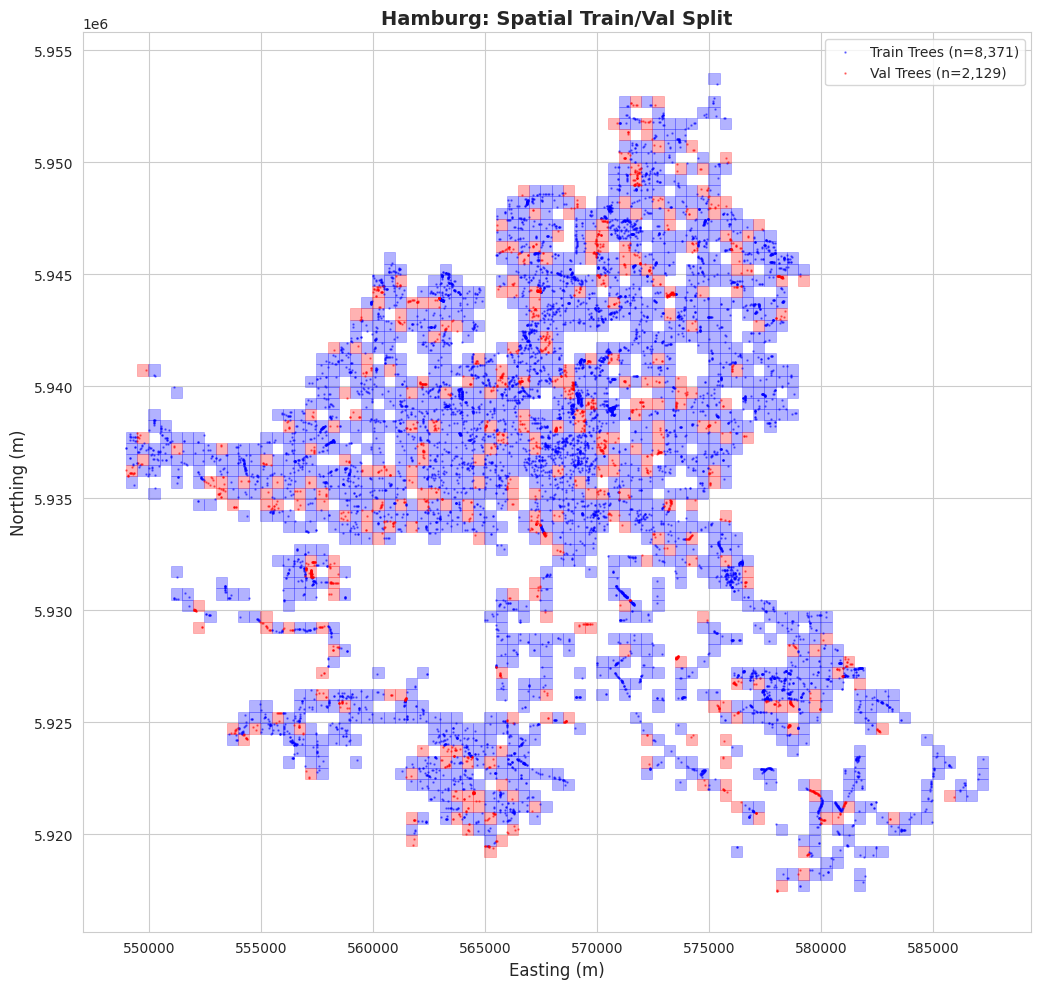

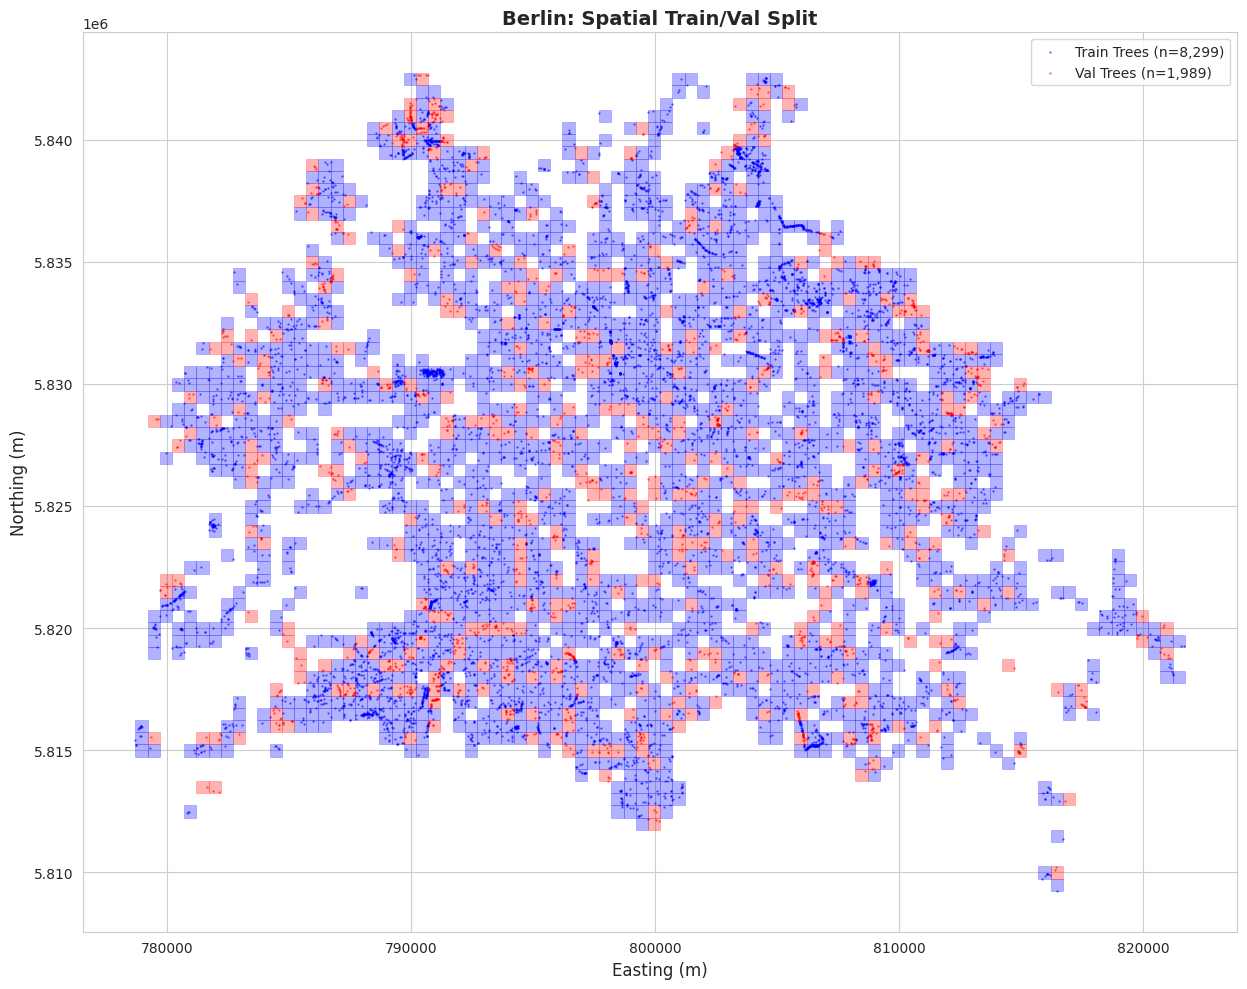

In [19]:
def plot_spatial_split(gdf_train, gdf_val, blocks_gdf, city_name, train_blocks, val_blocks):
    """
    Visualisiert Train/Val Split räumlich.
    """
    fig, ax = plt.subplots(figsize=(14, 10))

    # Markiere Train/Val Blöcke
    train_blocks_gdf = blocks_gdf[blocks_gdf['block_id'].isin(train_blocks)]
    val_blocks_gdf = blocks_gdf[blocks_gdf['block_id'].isin(val_blocks)]

    train_blocks_gdf.plot(ax=ax, color='blue', alpha=0.3, edgecolor='blue', linewidth=0.5, label='Train Blocks')
    val_blocks_gdf.plot(ax=ax, color='red', alpha=0.3, edgecolor='red', linewidth=0.5, label='Val Blocks')

    # Bäume plotten
    gdf_train.plot(ax=ax, color='blue', markersize=0.5, alpha=0.5, label=f'Train Trees (n={len(gdf_train):,})')
    gdf_val.plot(ax=ax, color='red', markersize=0.5, alpha=0.5, label=f'Val Trees (n={len(gdf_val):,})')

    ax.set_title(f'{city_name.capitalize()}: Spatial Train/Val Split', fontsize=14, fontweight='bold')
    ax.set_xlabel('Easting (m)', fontsize=12)
    ax.set_ylabel('Northing (m)', fontsize=12)
    ax.legend(loc='upper right', fontsize=10)
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()

# Hamburg
plot_spatial_split(hamburg_train, hamburg_val, blocks_gdf_dict['Hamburg'], 'Hamburg', hamburg_train_blocks, hamburg_val_blocks)

# Berlin
plot_spatial_split(berlin_train, berlin_val, blocks_gdf_dict['Berlin'], 'Berlin', berlin_train_blocks, berlin_val_blocks)

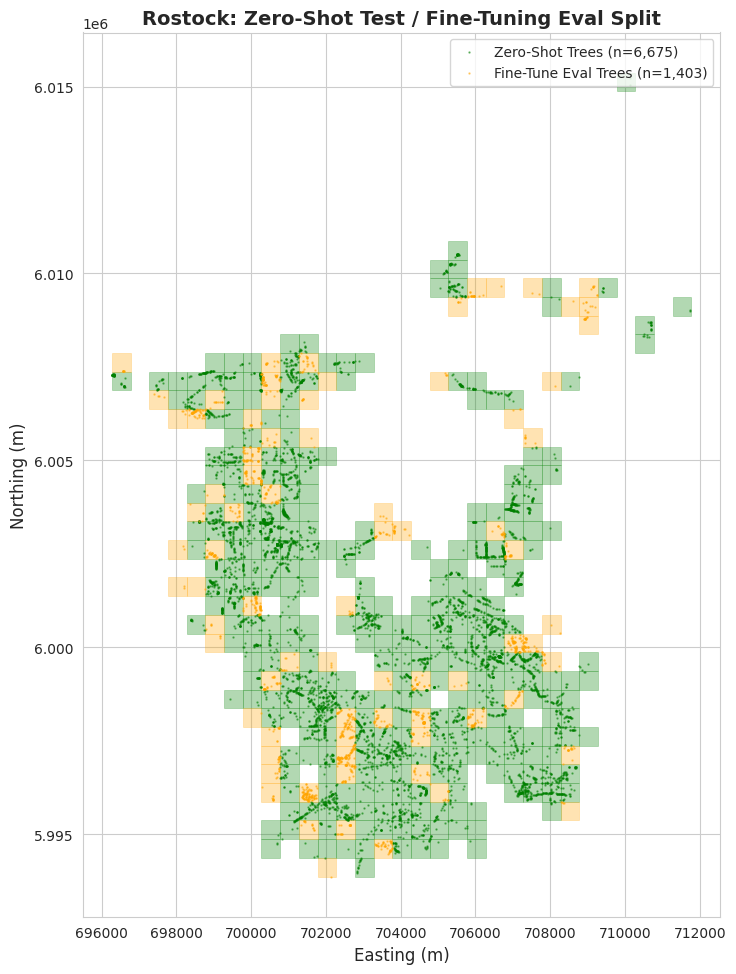

In [21]:
# Rostock
fig, ax = plt.subplots(figsize=(14, 10))

zs_blocks_gdf = blocks_gdf_dict['Rostock'][blocks_gdf_dict['Rostock']['block_id'].isin(rostock_zs_blocks)]
ft_blocks_gdf = blocks_gdf_dict['Rostock'][blocks_gdf_dict['Rostock']['block_id'].isin(rostock_ft_blocks)]

zs_blocks_gdf.plot(ax=ax, color='green', alpha=0.3, edgecolor='green', linewidth=0.5, label='Zero-Shot Test Blocks')
ft_blocks_gdf.plot(ax=ax, color='orange', alpha=0.3, edgecolor='orange', linewidth=0.5, label='Fine-Tune Eval Blocks')

rostock_zero_shot.plot(ax=ax, color='green', markersize=0.5, alpha=0.5, label=f'Zero-Shot Trees (n={len(rostock_zero_shot):,})')
rostock_finetune_eval.plot(ax=ax, color='orange', markersize=0.5, alpha=0.5, label=f'Fine-Tune Eval Trees (n={len(rostock_finetune_eval):,})')

ax.set_title('Rostock: Zero-Shot Test / Fine-Tuning Eval Split', fontsize=14, fontweight='bold')
ax.set_xlabel('Easting (m)', fontsize=12)
ax.set_ylabel('Northing (m)', fontsize=12)
ax.legend(loc='upper right', fontsize=10)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

## 11. Visualisierung: Gattungsverteilung

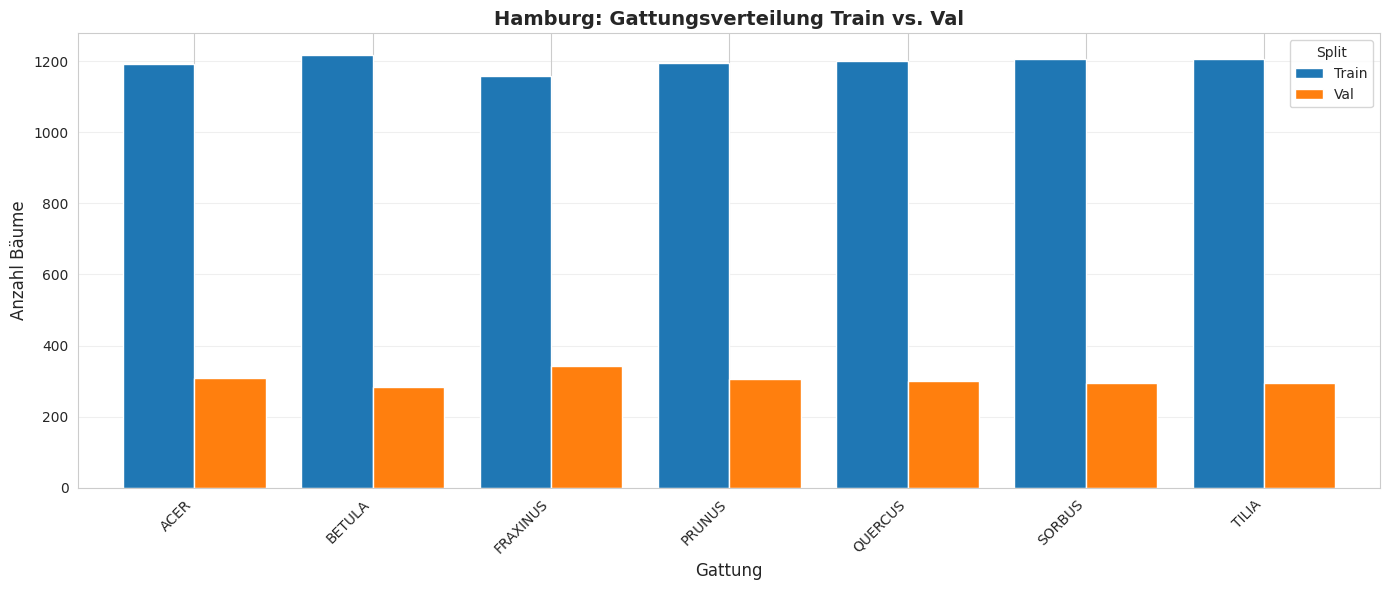

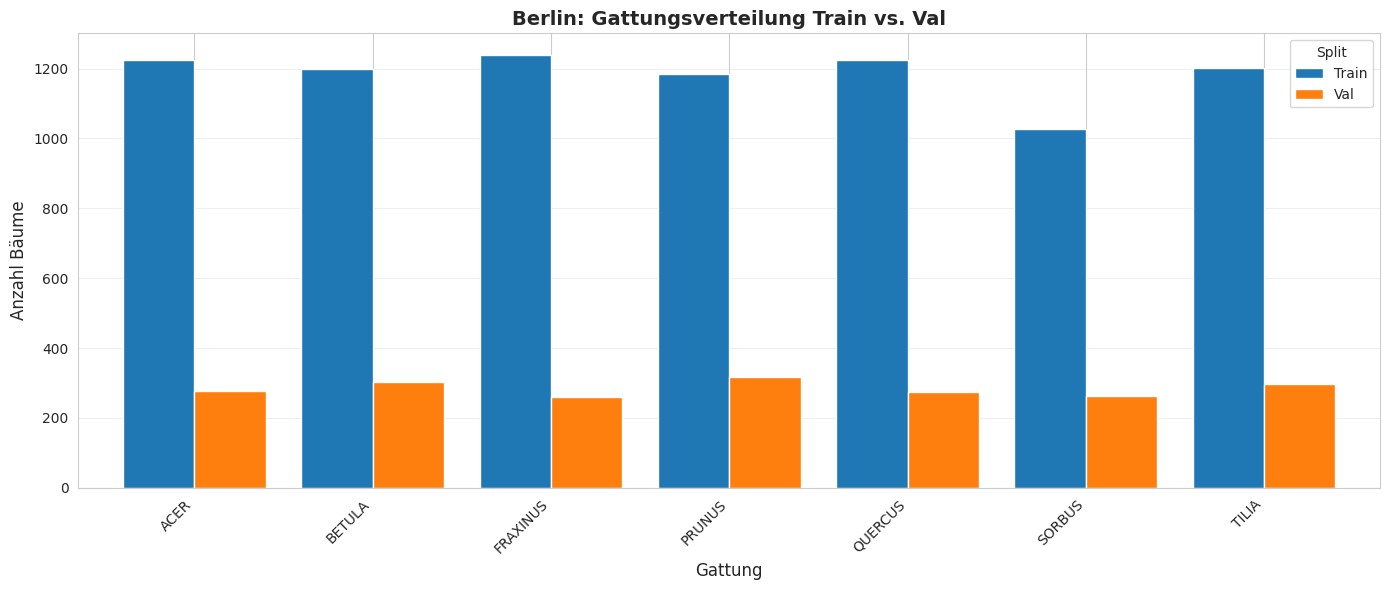

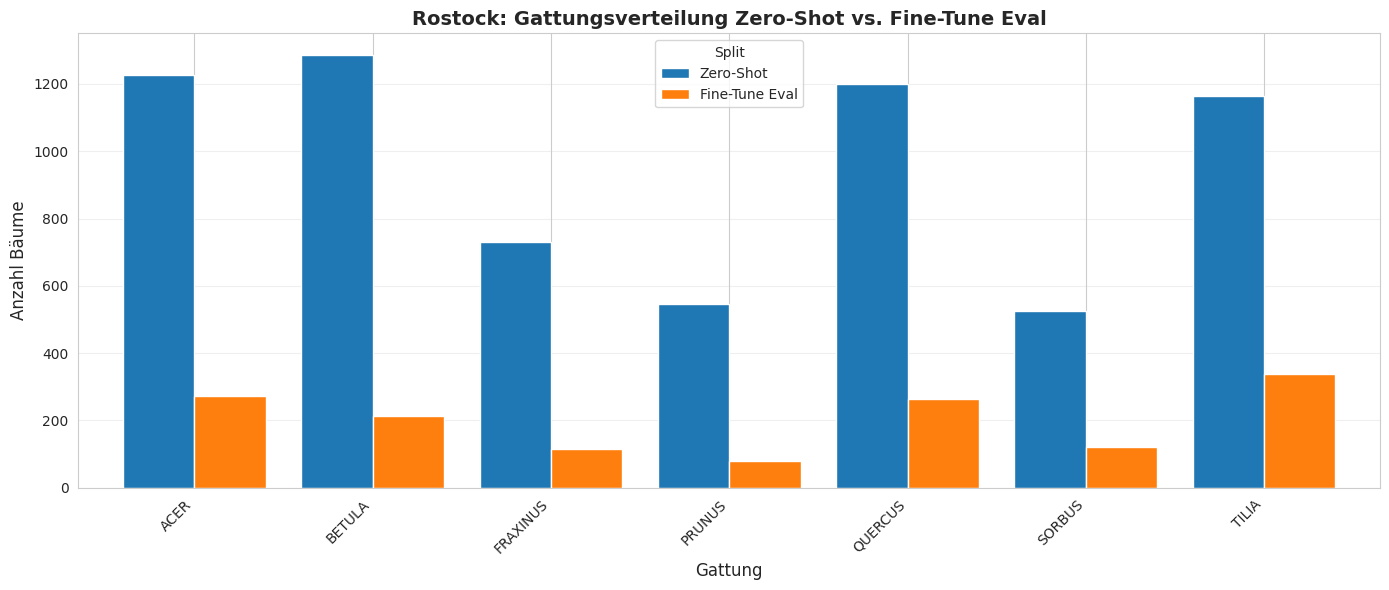

In [22]:
def plot_genus_distribution(splits_dict, title):
    """
    Balkendiagramm der Gattungsverteilung pro Split.
    """
    # Gattungszählungen pro Split
    genus_counts = {}
    for name, gdf in splits_dict.items():
        counts = gdf['genus_latin'].value_counts()
        genus_counts[name] = counts

    # DataFrame erstellen
    df = pd.DataFrame(genus_counts).fillna(0).astype(int)

    # Plot
    fig, ax = plt.subplots(figsize=(14, 6))
    df.plot(kind='bar', ax=ax, width=0.8)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Gattung', fontsize=12)
    ax.set_ylabel('Anzahl Bäume', fontsize=12)
    ax.legend(title='Split', fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Hamburg
plot_genus_distribution(
    {'Train': hamburg_train, 'Val': hamburg_val},
    'Hamburg: Gattungsverteilung Train vs. Val'
)

# Berlin
plot_genus_distribution(
    {'Train': berlin_train, 'Val': berlin_val},
    'Berlin: Gattungsverteilung Train vs. Val'
)

# Rostock
plot_genus_distribution(
    {'Zero-Shot': rostock_zero_shot, 'Fine-Tune Eval': rostock_finetune_eval},
    'Rostock: Gattungsverteilung Zero-Shot vs. Fine-Tune Eval'
)

## 12. Export: GPKG-Dateien

In [23]:
# Export Splits als GPKG
print('Exportiere Splits...')

splits_to_export = {
    'hamburg_train.gpkg': hamburg_train,
    'hamburg_val.gpkg': hamburg_val,
    'berlin_train.gpkg': berlin_train,
    'berlin_val.gpkg': berlin_val,
    'rostock_zero_shot.gpkg': rostock_zero_shot,
    'rostock_finetune_eval.gpkg': rostock_finetune_eval,
}

for filename, gdf in splits_to_export.items():
    output_path = SPLITS_DIR / filename
    gdf.to_file(output_path, driver='GPKG')
    print(f'  ✅ {filename} ({len(gdf):,} Bäume)')

print('\n✅ GPKG-Export abgeschlossen')

Exportiere Splits...
  ✅ hamburg_train.gpkg (8,371 Bäume)
  ✅ hamburg_val.gpkg (2,129 Bäume)
  ✅ berlin_train.gpkg (8,299 Bäume)
  ✅ berlin_val.gpkg (1,989 Bäume)
  ✅ rostock_zero_shot.gpkg (6,675 Bäume)
  ✅ rostock_finetune_eval.gpkg (1,403 Bäume)

✅ GPKG-Export abgeschlossen


## 13. Export: Block Assignments CSV

In [24]:
# Block Assignments
block_assignments = []

# Hamburg
for block_id in hamburg_train_blocks:
    block_assignments.append({'city': 'hamburg', 'block_id': block_id, 'split': 'train'})
for block_id in hamburg_val_blocks:
    block_assignments.append({'city': 'hamburg', 'block_id': block_id, 'split': 'val'})

# Berlin
for block_id in berlin_train_blocks:
    block_assignments.append({'city': 'berlin', 'block_id': block_id, 'split': 'train'})
for block_id in berlin_val_blocks:
    block_assignments.append({'city': 'berlin', 'block_id': block_id, 'split': 'val'})

# Rostock
for block_id in rostock_zs_blocks:
    block_assignments.append({'city': 'rostock', 'block_id': block_id, 'split': 'zero_shot'})
for block_id in rostock_ft_blocks:
    block_assignments.append({'city': 'rostock', 'block_id': block_id, 'split': 'finetune_eval'})

# DataFrame erstellen
block_assignments_df = pd.DataFrame(block_assignments)

# Export
output_path = SPLITS_DIR / 'block_assignments.csv'
block_assignments_df.to_csv(output_path, index=False)
print(f'✅ Block Assignments exportiert: {output_path}')
print(f'   {len(block_assignments_df)} Blöcke gesamt')

✅ Block Assignments exportiert: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/splits/block_assignments.csv
   4319 Blöcke gesamt


## 14. Export: Split Statistics CSV

In [25]:
# Split Statistics
statistics = []

for name, gdf in splits_to_export.items():
    split_name = name.replace('.gpkg', '')

    # Gesamt
    total = len(gdf)
    n_blocks = gdf['block_id'].nunique()

    # Pro Gattung
    genus_counts = gdf['genus_latin'].value_counts()

    for genus in VIABLE_GENERA:
        count = genus_counts.get(genus, 0)
        statistics.append({
            'split': split_name,
            'genus': genus,
            'n_trees': count,
            'n_blocks': n_blocks,
            'total_trees': total
        })

# DataFrame erstellen
statistics_df = pd.DataFrame(statistics)

# Export
output_path = SPLITS_DIR / 'split_statistics.csv'
statistics_df.to_csv(output_path, index=False)
print(f'✅ Split Statistics exportiert: {output_path}')
print(f'   {len(statistics_df)} Einträge')

✅ Split Statistics exportiert: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/splits/split_statistics.csv
   42 Einträge


## 15. Zusammenfassung

In [26]:
print('\n' + '='*60)
print('PHASE 4 ABGESCHLOSSEN: Spatial Block Split')
print('='*60)

print('\n📊 SPLIT STATISTIK:')
print('\nHamburg:')
print(f'  Train: {len(hamburg_train):,} Bäume, {len(hamburg_train_blocks)} Blöcke')
print(f'  Val:   {len(hamburg_val):,} Bäume, {len(hamburg_val_blocks)} Blöcke')

print('\nBerlin:')
print(f'  Train: {len(berlin_train):,} Bäume, {len(berlin_train_blocks)} Blöcke')
print(f'  Val:   {len(berlin_val):,} Bäume, {len(berlin_val_blocks)} Blöcke')

print('\nRostock:')
print(f'  Zero-Shot Test:     {len(rostock_zero_shot):,} Bäume, {len(rostock_zs_blocks)} Blöcke')
print(f'  Fine-Tuning Eval:   {len(rostock_finetune_eval):,} Bäume, {len(rostock_ft_blocks)} Blöcke')

print('\n📁 EXPORTIERTE DATEIEN:')
print(f'  {SPLITS_DIR}/')
for filename in splits_to_export.keys():
    print(f'    ✅ {filename}')
print(f'    ✅ block_assignments.csv')
print(f'    ✅ split_statistics.csv')

print('\n✅ ALLE CHECKS BESTANDEN')
print('\n⏭️  NÄCHSTER SCHRITT: Phase 5 - Feature Extraction')


PHASE 4 ABGESCHLOSSEN: Spatial Block Split

📊 SPLIT STATISTIK:

Hamburg:
  Train: 8,371 Bäume, 1352 Blöcke
  Val:   2,129 Bäume, 335 Blöcke

Berlin:
  Train: 8,299 Bäume, 1789 Blöcke
  Val:   1,989 Bäume, 457 Blöcke

Rostock:
  Zero-Shot Test:     6,675 Bäume, 308 Blöcke
  Fine-Tuning Eval:   1,403 Bäume, 78 Blöcke

📁 EXPORTIERTE DATEIEN:
  /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/splits/
    ✅ hamburg_train.gpkg
    ✅ hamburg_val.gpkg
    ✅ berlin_train.gpkg
    ✅ berlin_val.gpkg
    ✅ rostock_zero_shot.gpkg
    ✅ rostock_finetune_eval.gpkg
    ✅ block_assignments.csv
    ✅ split_statistics.csv

✅ ALLE CHECKS BESTANDEN

⏭️  NÄCHSTER SCHRITT: Phase 5 - Feature Extraction
